In [ ]:
!pip install pennylane --upgrade
!pip install torchvision
!pip install kahypar

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import torchvision
from torchvision import transforms

import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer, RMSPropOptimizer

from sklearn.model_selection import train_test_split
from IPython.display import clear_output

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


data = torchvision.datasets.MNIST("mnist", download=True)


transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize((9, 7))
    ]
)


def unison_shuffle(a, b):
    assert len(a) == len(b)
    p = torch.randperm(len(a))
    return a[p], b[p]


zeros = list(map(lambda x: transform(x[0]), filter(lambda x: x[1] == 0, data)))
ones  = list(map(lambda x: transform(x[0]), filter(lambda x: x[1] == 1, data)))

min_length = 150 # min(len(zeros), len(ones))
zeros, ones = zeros[:min_length], ones[:min_length]

x_data = torch.Tensor(size=(2*min_length, 9, 7))
y_data = torch.Tensor(size=(2*min_length,))

zeros_labels = torch.Tensor([0 for i in range(min_length)])
ones_labels = torch.Tensor([1 for i in range(min_length)])

torch.cat([*zeros, *ones], out=x_data)
torch.cat([zeros_labels, ones_labels], out=y_data)

x_data, y_data = unison_shuffle(x_data, y_data)

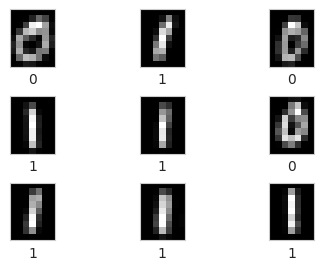

In [16]:
fig, ax = plt.subplots(3, 3, figsize=(5, 3), subplot_kw={"xticks": [], "yticks": []})
for i in range(9):
    ax[i // 3, i % 3].set_xlabel(str(int(y_data[i])))
    ax[i // 3, i % 3].imshow(
        transforms.functional.to_pil_image(x_data[i]),
        aspect="equal",
        cmap='gray'
    )
plt.subplots_adjust(wspace=0.01, hspace=0.5)

In [17]:
dev = qml.device("lightning.qubit", wires=4)


def density_matrix(state):
    return state * np.conj(state).T


@qml.qnode(dev, interface='torch')
def qcirc(image, params, y):
    """
    image : (4, 3)
    params: (3,)
    """
    for i, row in enumerate(image):
        qml.RX(row[0], wires=i)
        qml.RY(row[1], wires=i)
        qml.RX(row[2], wires=i)


    qml.ISWAP(wires=[1, 0])
    qml.ISWAP(wires=[2, 1])
    qml.ISWAP(wires=[3, 2])

    for i, row in enumerate(image):
        qml.RY(row[0], wires=i)
        qml.RX(row[1], wires=i)
        qml.RY(row[2], wires=i)


    qml.ISWAP(wires=[3, 2])
    qml.ISWAP(wires=[2, 1])
    qml.ISWAP(wires=[1, 0])


    qml.RX(params[0], wires=0)
    qml.RY(params[1], wires=0)
    qml.RX(params[2], wires=0)


    return qml.expval(qml.Hermitian(y, wires=[0]))

/usr/local/lib/python3.10/dist-packages/pennylane/math/utils.py:227: UserWarning: Contains tensors of types {'autograd', 'torch'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


(<Figure size 1800x500 with 1 Axes>, <Axes: >)

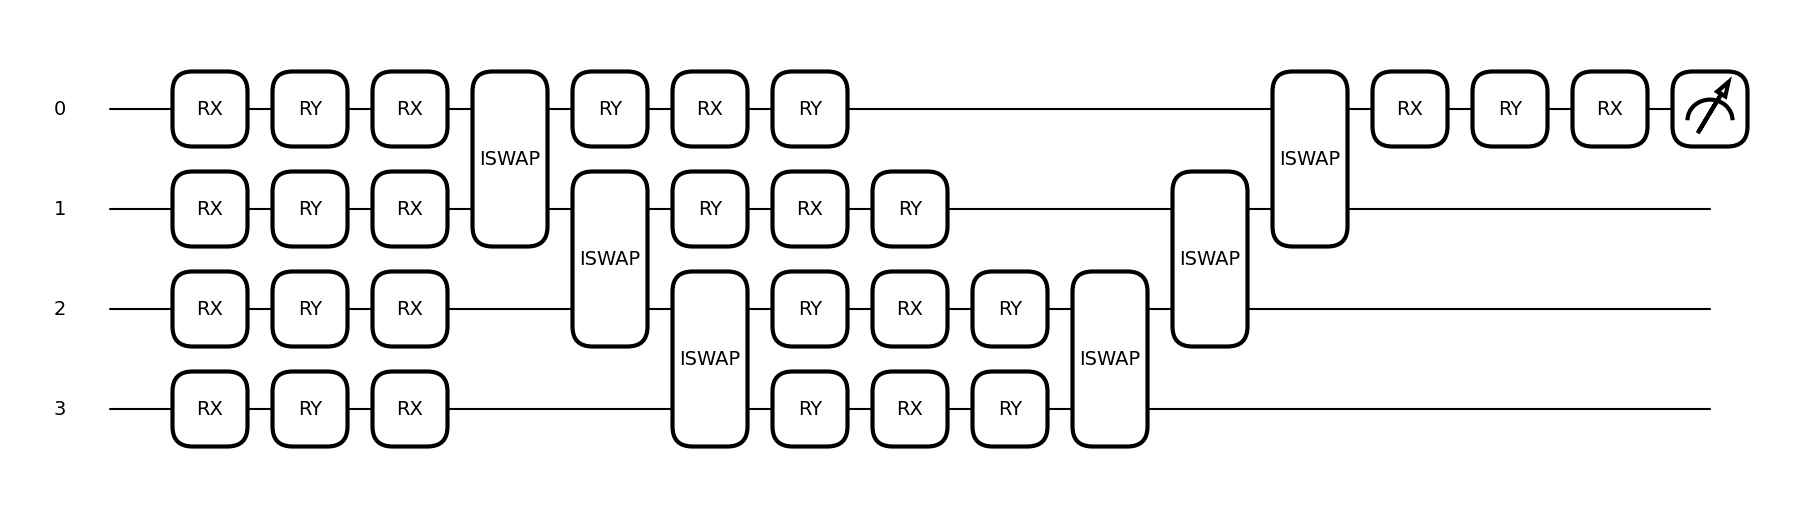

In [18]:
label_1 = [[1.], [0.]]
label_0 = [[0.], [1.]]
state_labels = torch.Tensor([label_0, label_1])
state_labels.requires_grad=False

trainable = nn.Parameter(
    torch.rand(size=(3,)),
    requires_grad=True
)
kernel = nn.Parameter(
    torch.rand(size=(1, 1, 3, 3)),
    requires_grad=True
)
bias = nn.Parameter(
    torch.rand(size=(1,)),
    requires_grad=True
)

qml.draw_mpl(qcirc)(torch.rand(size=(4, 3)), trainable, density_matrix(label_0))

In [22]:
from sklearn.metrics import accuracy_score, f1_score


def cost(params, images, y):
    loss = 0.0
    dm_labels = [torch.Tensor(density_matrix(s)) for s in state_labels]

    conv = nn.Conv2d(
        in_channels=1,
        out_channels=1,
        kernel_size=3,
        stride=2,
        bias=True
    )

    conv.weight = params["kernel"]
    conv.bias = params["bias"]

    for i in range(len(images)):
        # forward pass

        img = images[i].reshape(1, 1, 9, 7)
        # (1, 1, 9, 7) -> (4, 3)
        img = conv(img).squeeze(0).squeeze(0)
        f = qcirc(img, params["trainable"], dm_labels[int(y[i])])
        # compute loss
        loss = loss + (1 - f) ** 2

    return loss / len(images)



def get_batch(inputs, targets, batch_size):
    for start_idx in range(0, inputs.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield inputs[idxs], targets[idxs]


def plot_history(acc1, acc2):
    clear_output(wait=True)

    fig, axes = plt.subplots(1, 2, figsize=(30, 7), sharey=True)
    sns.set_style("whitegrid")
    k = list(range(1, len(acc1)+1))


    axes[0].set(xlabel='epochs', ylabel='train accuracy')
    axes[1].set(xlabel='epochs', ylabel='test accuracy')
    sns.lineplot(x=k, y=acc1, ax=axes[0])
    sns.lineplot(x=k, y=acc2, ax=axes[1])

    plt.show()


def test(params, x, y):
    dm_labels = [torch.Tensor(density_matrix(s)) for s in state_labels]
    predicted = []

    conv = nn.Conv2d(
        in_channels=1,
        out_channels=1,
        kernel_size=3,
        stride=2,
        bias=True
    )

    conv.weight = params["kernel"]
    conv.bias = params["bias"]


    for i in range(len(x)):
        img = x[i].reshape(1, 1, 9, 7)
        # (1, 1, 9, 7) -> (4, 3)
        img = conv(img).squeeze(0).squeeze(0)
        fidel_function = lambda y: qcirc(img, params["trainable"], y)
        fidelities = torch.Tensor([fidel_function(dm) for dm in dm_labels])
        best_fidel = torch.argmax(fidelities)
        predicted.append(float(best_fidel.detach().numpy()))

    return predicted


In [28]:
def train(X_train: np.array, Y_train: np.array,
          X_test: np.array, Y_test: np.array,
          params):

    opt = Adam([params["trainable"], params["kernel"], params["bias"]], lr=0.001)
    train_acc_history, test_acc_history = [], []
    for _ in range(25):
        for x, y in get_batch(X_train, Y_train, batch_size=20):
            opt.zero_grad()
            loss = cost(params, x, y)
            loss.backward()
            opt.step()


        predicted_train = test(params, X_train, Y_train)
        acc_train = accuracy_score(Y_train, predicted_train)

        predicted_test = test(params, X_test, Y_test)
        acc_test = accuracy_score(Y_test, predicted_test)


        train_acc_history.append(acc_train)
        test_acc_history.append(acc_test)

        plot_history(
            train_acc_history,
            test_acc_history
        )


    return (
        train_acc_history,
        test_acc_history
    )

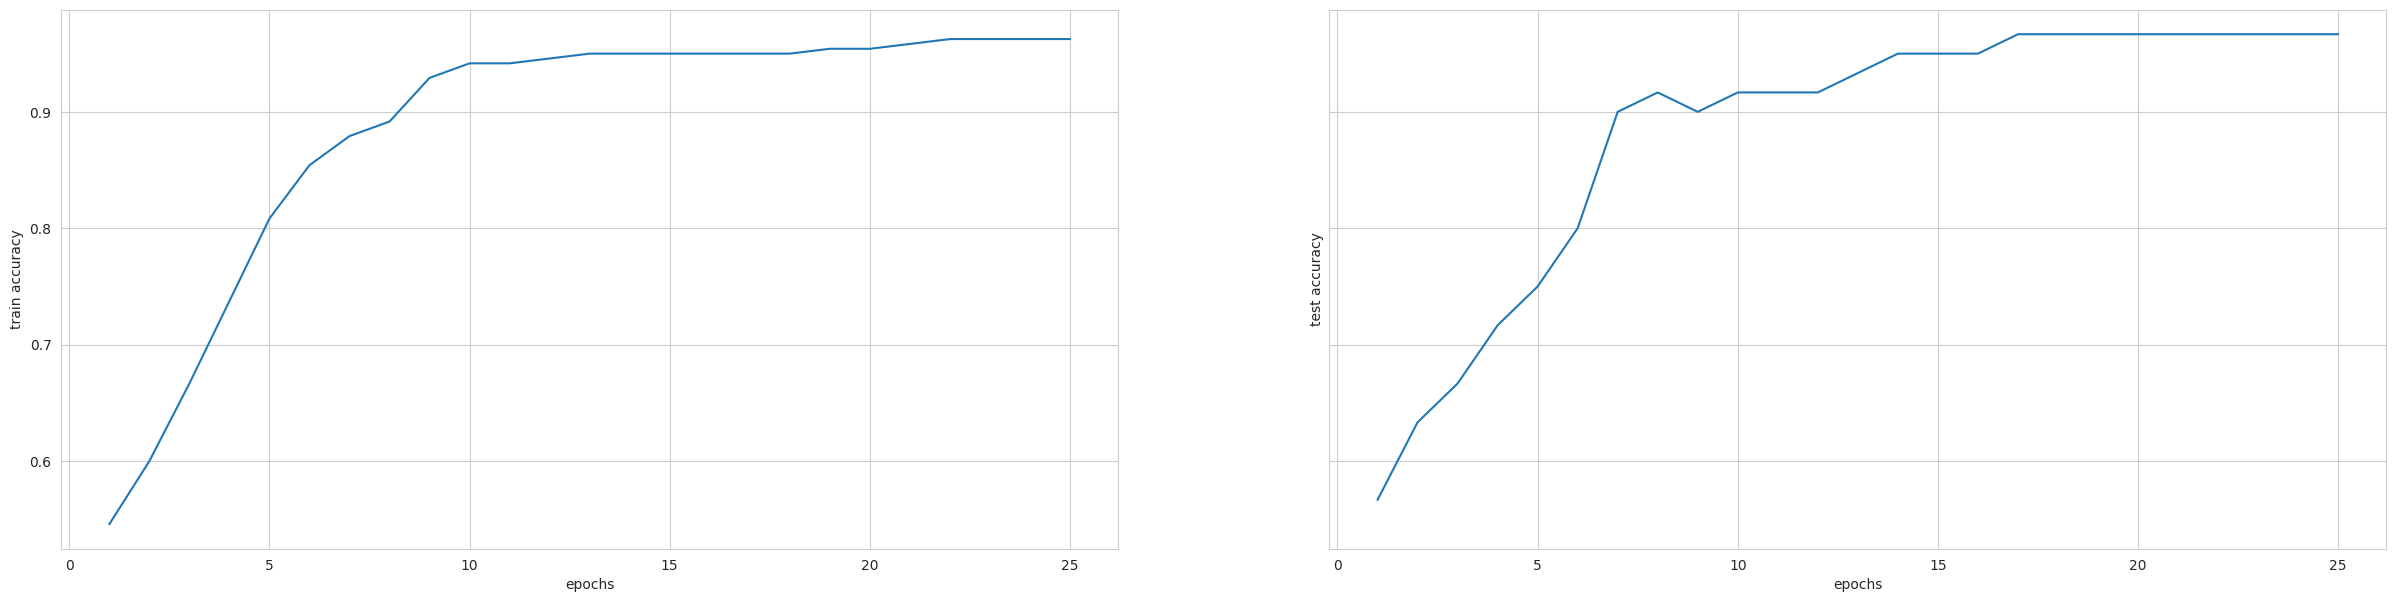

In [29]:
train_x, test_x, train_y, test_y = train_test_split(
    x_data,
    y_data,
    train_size=0.8,
    random_state=422
)


train_f1, test_f1 = [], []


params = {
    "trainable": nn.Parameter(
        torch.rand(size=(3,), dtype=torch.float32),
        requires_grad=True
    ),
    "kernel": nn.Parameter(
        torch.rand(size=(1, 1, 3, 3), dtype=torch.float32),
        requires_grad=True
    ),
    "bias": nn.Parameter(
        torch.rand(size=(1,), dtype=torch.float32),
        requires_grad=True
    )
}


train_f1, test_f1 = train(
    train_x, train_y, test_x, test_y,
    params
)

In [32]:
print(max(train_f1), max(test_f1))

0.9625 0.9666666666666667
